In [1]:
import os, math, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def print_metrics(name, y_true, y_pred):
    print(f"\n[{name}]")
    print(f"RMSE: {rmse(y_true, y_pred):.3f}")
    print(f"MAE : {mean_absolute_error(y_true, y_pred):.3f}")
    print(f"R^2 : {r2_score(y_true, y_pred):.4f}")

In [4]:
# Matplotlib defaults
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

In [ ]:
# 1) Load real-world data
# California Housing: target is median house value (in 100k USD)
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

print("Columns:", list(X.columns))
print("Rows:", len(X))

Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Rows: 20640


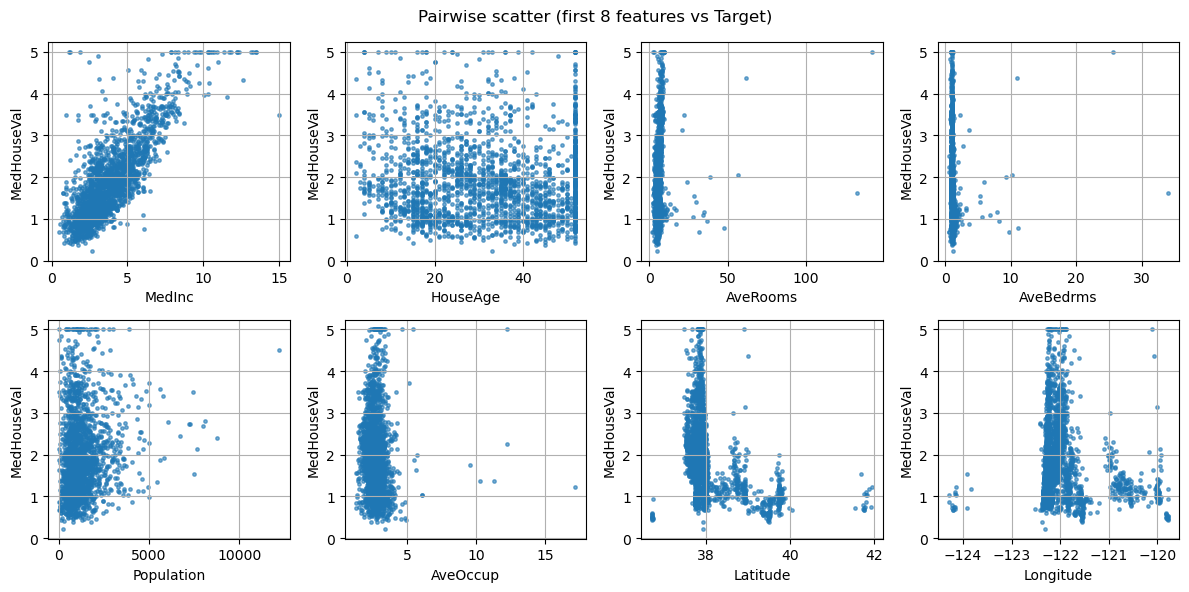

In [6]:
# Quick sanity plots (optional)
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()
for i, col in enumerate(X.columns[:8]):
    axes[i].scatter(X[col].values[:2000], y.values[:2000], s=6, alpha=0.6)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("MedHouseVal")
fig.suptitle("Pairwise scatter (first 8 features vs Target)")
plt.tight_layout()
plt.show()

In [ ]:
# 2) Train/Val/Test split
# 60% train, 20% val, 20% test (classic workflow to mimic your assignment)
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.25, random_state=RANDOM_SEED
)  # 0.25 of 0.8 = 0.2

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (12384, 8), Val: (4128, 8), Test: (4128, 8)



[Baseline: 1-feature Linear (MedInc) — Train]
RMSE: 0.834
MAE : 0.623
R^2 : 0.4750

[Baseline: 1-feature Linear (MedInc) — Val]
RMSE: 0.843
MAE : 0.631
R^2 : 0.4827


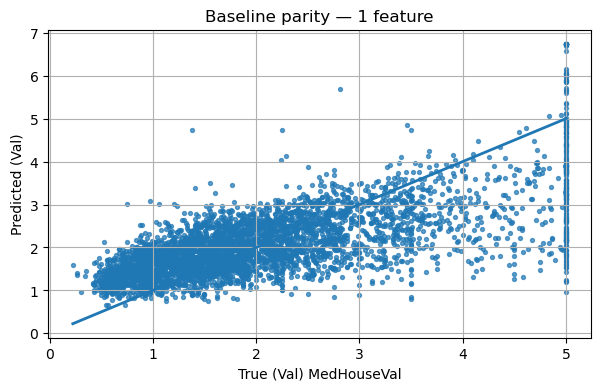

In [ ]:
# 3) Baseline: Simple 1-feature Linear Regression
# Use just 'MedInc' as a baseline signal
Xtr1 = X_train[["MedInc"]].values
Xva1 = X_val[["MedInc"]].values
Xte1 = X_test[["MedInc"]].values

lin1 = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])
lin1.fit(Xtr1, y_train)

y_tr_pred = lin1.predict(Xtr1)
y_va_pred = lin1.predict(Xva1)
y_te_pred = lin1.predict(Xte1)

print_metrics("Baseline: 1-feature Linear (MedInc) — Train", y_train, y_tr_pred)
print_metrics("Baseline: 1-feature Linear (MedInc) — Val",   y_val,   y_va_pred)

# Parity plot (Val)
plt.scatter(y_val, y_va_pred, s=8, alpha=0.7)
plt.xlabel("True (Val) MedHouseVal")
plt.ylabel("Predicted (Val)")
plt.title("Baseline parity — 1 feature")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], lw=2)
plt.show()

In [ ]:
# 4) Multivariate Linear Regression (all features)
lin_all = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])
lin_all.fit(X_train, y_train)
y_val_pred_all = lin_all.predict(X_val)
print_metrics("Linear Regression (all features) — Val", y_val, y_val_pred_all)


[Linear Regression (all features) — Val]
RMSE: 0.728
MAE : 0.533
R^2 : 0.6142



Polynomial Regression (no regularization) — summary:


,degree,train_rmse,val_rmse,r2_val
0,1,0.717203,7.278380e-01,6.142001e-01
1,2,0.649046,9.546334e-01,3.363089e-01
2,3,0.582552,1.468894e+03,-1.571352e+06
3,4,0.528126,2.250467e+04,-3.688401e+08
4,5,0.486808,2.296682e+08,-3.841443e+16


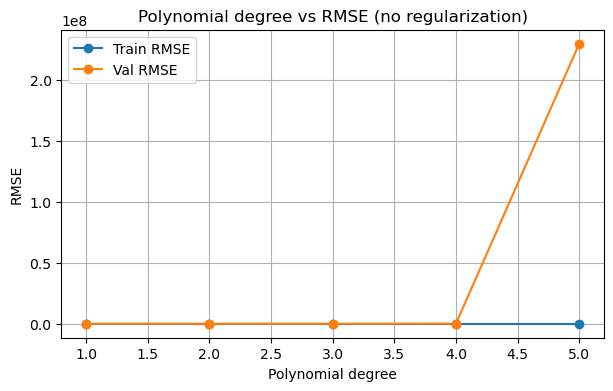

Best degree (by Val RMSE): 1


In [ ]:
# 5) Polynomial Regression (degree sweep)
degrees = range(1, 6)  # 1..5
results_poly = []

for deg in degrees:
    model = Pipeline([
        ("scaler", StandardScaler(with_mean=False) if deg > 1 else StandardScaler()),
        # include_bias=False because LinearRegression adds intercept
        ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
        ("linreg", LinearRegression())
    ])
    model.fit(X_train, y_train)
    y_tr = model.predict(X_train)
    y_va = model.predict(X_val)

    res = {
        "degree": deg,
        "train_rmse": rmse(y_train, y_tr),
        "val_rmse": rmse(y_val, y_va),
        "r2_val": r2_score(y_val, y_va)
    }
    results_poly.append(res)

poly_df = pd.DataFrame(results_poly)
print("\nPolynomial Regression (no regularization) — summary:")
display(poly_df)

# Plot RMSE vs degree
plt.plot(poly_df["degree"], poly_df["train_rmse"], marker="o", label="Train RMSE")
plt.plot(poly_df["degree"], poly_df["val_rmse"], marker="o", label="Val RMSE")
plt.xlabel("Polynomial degree")
plt.ylabel("RMSE")
plt.title("Polynomial degree vs RMSE (no regularization)")
plt.legend()
plt.show()

best_row = poly_df.sort_values("val_rmse", ascending=True).iloc[0]
best_deg = int(best_row["degree"])
print(f"Best degree (by Val RMSE): {best_deg}")


Ridge (degree=2) — summary (sorted by Val RMSE):


,alpha,train_rmse,val_rmse,r2_val
10,5.080218,0.663533,0.777594,0.559650
7,0.196842,0.652987,0.785885,0.550209
8,0.581709,0.656538,0.786786,0.549177
9,1.719072,0.660644,0.791963,0.543224
11,15.013107,0.664914,0.794749,0.540005
6,0.066608,0.650647,0.807885,0.524673
5,0.022539,0.649467,0.863611,0.456839
4,0.007627,0.649119,0.913943,0.391682
3,0.002581,0.649056,0.939334,0.357412
2,0.000873,0.649047,0.949261,0.343758


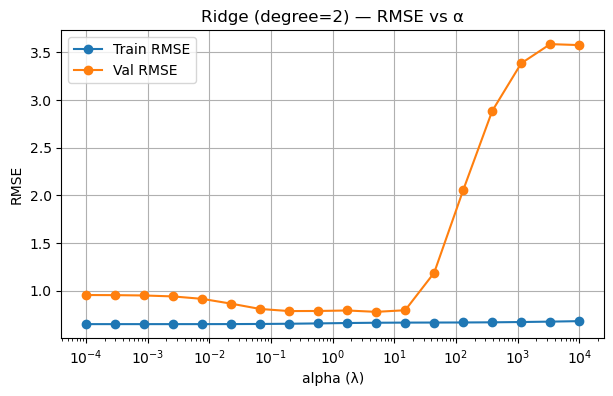

Best alpha (by Val RMSE): 5.08022


In [ ]:
# 6) Ridge Regularization (degree fixed)
# We'll regularize a moderately expressive polynomial model to balance bias-variance
degree_for_ridge = max(2, best_deg)  # ensure >=2 to make ridge meaningful with poly
alphas = np.logspace(-4, 4, 18)      # 1e-4 ... 1e4

ridge_results = []
for alpha in alphas:
    model = Pipeline([
        ("scaler", StandardScaler(with_mean=False) if degree_for_ridge > 1 else StandardScaler()),
        ("poly", PolynomialFeatures(degree=degree_for_ridge, include_bias=False)),
        ("ridge", Ridge(alpha=alpha, random_state=RANDOM_SEED))
    ])
    model.fit(X_train, y_train)
    y_tr = model.predict(X_train)
    y_va = model.predict(X_val)

    ridge_results.append({
        "alpha": alpha,
        "train_rmse": rmse(y_train, y_tr),
        "val_rmse": rmse(y_val, y_va),
        "r2_val": r2_score(y_val, y_va)
    })

ridge_df = pd.DataFrame(ridge_results)
print(f"\nRidge (degree={degree_for_ridge}) — summary (sorted by Val RMSE):")
display(ridge_df.sort_values("val_rmse").head(10))

# Plot RMSE vs alpha (log x-axis)
plt.semilogx(ridge_df["alpha"], ridge_df["train_rmse"], marker="o", label="Train RMSE")
plt.semilogx(ridge_df["alpha"], ridge_df["val_rmse"], marker="o", label="Val RMSE")
plt.xlabel("alpha (λ)")
plt.ylabel("RMSE")
plt.title(f"Ridge (degree={degree_for_ridge}) — RMSE vs α")
plt.legend()
plt.show()

best_row = ridge_df.sort_values("val_rmse", ascending=True).iloc[0]
best_alpha = float(best_row["alpha"])
print(f"Best alpha (by Val RMSE): {best_alpha:g}")

In [ ]:
# 7) K-Fold CV check (optional but solid)
cv_model = Pipeline([
    ("scaler", StandardScaler(with_mean=False) if degree_for_ridge > 1 else StandardScaler()),
    ("poly", PolynomialFeatures(degree=degree_for_ridge, include_bias=False)),
    ("ridge", Ridge(alpha=best_alpha, random_state=RANDOM_SEED))
])

# Note: scoring is negative MSE; we'll convert to RMSE
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
neg_mse_scores = cross_val_score(cv_model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)
cv_rmse = np.sqrt(-neg_mse_scores)
print(f"\n5-fold CV RMSE (Train set only): mean={cv_rmse.mean():.3f}, std={cv_rmse.std(ddof=1):.3f}")


5-fold CV RMSE (Train set only): mean=1.156, std=0.987



[FINAL (Train+Val→Test)]
RMSE: 0.683
MAE : 0.485
R^2 : 0.6435


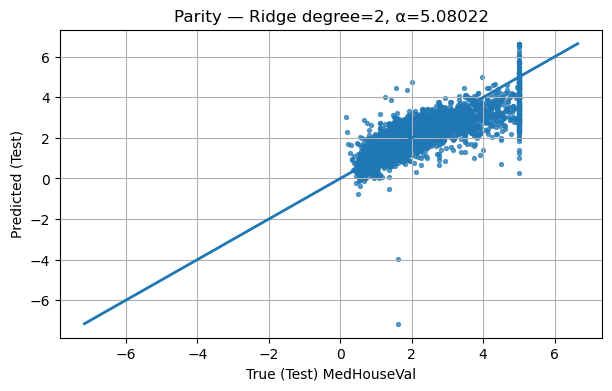

In [ ]:
# 8) Final training & Test evaluation
# =========================
# Retrain on Train + Val using best hyperparams and evaluate once on Test
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = pd.concat([y_train, y_val], axis=0)

final_model = Pipeline([
    ("scaler", StandardScaler(with_mean=False) if degree_for_ridge > 1 else StandardScaler()),
    ("poly", PolynomialFeatures(degree=degree_for_ridge, include_bias=False)),
    ("ridge", Ridge(alpha=best_alpha, random_state=RANDOM_SEED))
]).fit(X_trval, y_trval)

y_test_pred = final_model.predict(X_test)
print_metrics("FINAL (Train+Val→Test)", y_test, y_test_pred)

# Parity plot (Test)
plt.scatter(y_test, y_test_pred, s=8, alpha=0.7)
plt.xlabel("True (Test) MedHouseVal")
plt.ylabel("Predicted (Test)")
plt.title(f"Parity — Ridge degree={degree_for_ridge}, α={best_alpha:g}")
lims = [min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())]
plt.plot(lims, lims, lw=2)
plt.show()

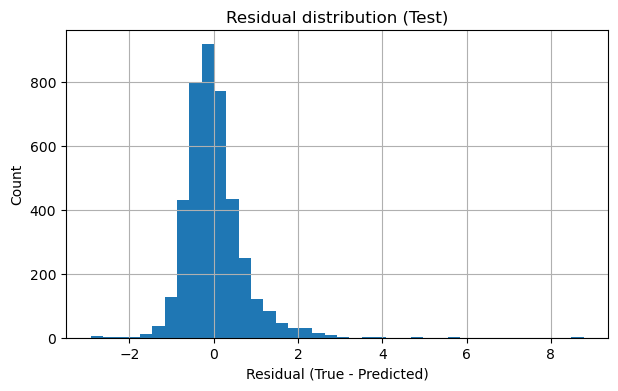

In [14]:
# Residuals
residuals = y_test - y_test_pred
plt.hist(residuals, bins=40)
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Count")
plt.title("Residual distribution (Test)")
plt.show()

In [ ]:
# 9) Save artifacts (model + report)
os.makedirs("artifacts", exist_ok=True)
joblib.dump(final_model, f"artifacts/house_price_model_ridge_deg{degree_for_ridge}_alpha{best_alpha}.joblib")

summary = {
    "random_seed": RANDOM_SEED,
    "best_degree_for_ridge": degree_for_ridge,
    "best_alpha": best_alpha,
    "cv_rmse_mean": float(cv_rmse.mean()),
    "cv_rmse_std": float(cv_rmse.std(ddof=1)),
    "test_rmse": rmse(y_test, y_test_pred),
    "test_mae": float(mean_absolute_error(y_test, y_test_pred)),
    "test_r2": float(r2_score(y_test, y_test_pred)),
    "features": list(X.columns)
}
with open("artifacts/summary.json", "w") as f:
    json.dump(summary, f, indent=2)

pd.DataFrame({
    "y_test": y_test.values,
    "y_pred": y_test_pred
}).to_csv("artifacts/test_predictions.csv", index=False)

print("\nSaved:")
print(" - artifacts/house_price_model_ridge_*.joblib")
print(" - artifacts/summary.json")
print(" - artifacts/test_predictions.csv")


Saved:
 - artifacts/house_price_model_ridge_*.joblib
 - artifacts/summary.json
 - artifacts/test_predictions.csv


In [ ]:
# 10) Example: Predict on new data
# Build a sample (mean-ish values). Adjust as needed.
sample = pd.DataFrame([{
    "MedInc": 5.0,         # median income in block group
    "HouseAge": 30.0,
    "AveRooms": 5.5,
    "AveBedrms": 1.0,
    "Population": 1000.0,
    "AveOccup": 3.0,
    "Latitude": 34.0,
    "Longitude": -118.0
}])

loaded = joblib.load(f"artifacts/house_price_model_ridge_deg{degree_for_ridge}_alpha{best_alpha}.joblib")
pred = loaded.predict(sample)[0]
print(f"\nSample prediction (MedHouseVal in $100k): {pred:.3f}  =>  ${pred*100000:,.0f}")


Sample prediction (MedHouseVal in $100k): 2.509  =>  $250,896
